In [1]:
from fastai import *
from fastai.vision.all import *
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from classifier_common import *
from heatmaps import *
from segmentation_data import *

(1024, 1024)


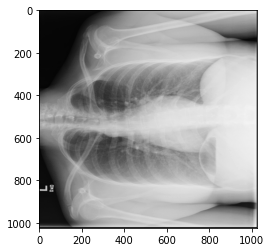

In [2]:
# img_file = "/data/datasets/extended_v2_Masked/test/COVID-19/9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg"
# img_file = "/data/datasets/extended_v2_Masked/test/COVID-19/1-s2.0-S0929664620300449-gr2_lrg-a.jpg"
# img_file = "/data/datasets/extended_v2_Masked/test/Normal/3bbcfb90-b950-4502-9866-82a131651a73.png"
# img_file = "/data/datasets/extended_v2_Masked/test/COVID-19/COVID-00030.jpg"
# img_file = "/data/datasets/extended_v2_Masked/evaluate/COVID-19/COVID-19-AR-16406541_02.png"
# img_file = "/data/datasets/extended_v2/test/5f9692fa-23cd-4ed0-a9db-5571482f6d11.png"
# img_file = "/data/datasets/extended_v2_Masked/test/COVID-19/figure1-5e7c1b8d98c29ab001275405-98.jpeg"
# img_file = "/data/datasets/extended_v2_Masked/test/Pneumonia/66bcb6f8-946f-4f66-8d18-06f17b01d3cd.png"
img_file = "/data/datasets/extended_v2_Masked/train/Normal/28b67d93-2432-41e4-9e3b-3d0ba249ad39.png"

# Identified as Pneumonia
# img_file = "/data/datasets/extended_v2_Masked/test/COVID-19/COVID-00035.jpg"

img = Image.open(img_file)
print(img.size)
width, height = img.size
plt.imshow(img, cmap='gray')
plt.show()
plt.close()

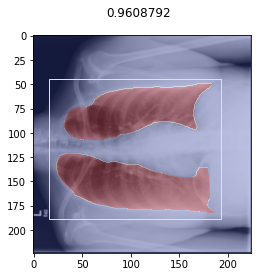

,x,y,width,height,confidence,class
file,,,,,,
/data/datasets/extended_v2_Masked/train/Normal/28b67d93-2432-41e4-9e3b-3d0ba249ad39.png,73,201,809,662,0.9608792,Normal


In [3]:
segmenter_model = "/data/output/NLM_Shenzhen_Montgomery-06/segmentation-model.pkl"
segmenter = load_learner(segmenter_model, cpu=False)
inp, mask, _, pred = segmenter.predict(img_file, with_input=True)
bounds = find_bounds(mask, padding=0.05)
confidence = compute_confidence_score(pred, mask)

regions_df = pd.DataFrame(data={
    "file": [img_file],
    "x": [int(bounds[0] / float(mask.shape[1]) * width)],
    "y": [int(bounds[1] / float(mask.shape[0]) * height)],
    "width": [int((bounds[2] - bounds[0]) / float(mask.shape[1]) * width)],
    "height": [int((bounds[3] - bounds[1]) / float(mask.shape[0]) * height)],
    "confidence": [confidence],
    "class": [parent_label(img_file)]
}).set_index("file")

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(inp.permute([1,2,0]), cmap='gray')
rect = patches.Rectangle((bounds[0], bounds[1]), bounds[2] - bounds[0], bounds[3] - bounds[1], linewidth=1, edgecolor='yellow', facecolor='none')
ax.add_patch(rect)
ax.imshow(mask, cmap='coolwarm', alpha=0.3)
fig.suptitle(confidence)
plt.show()
plt.close(fig)

regions_df

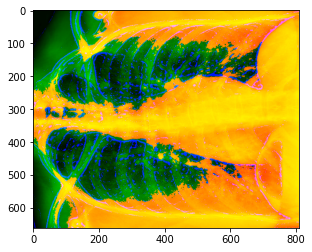

In [4]:
cropper = InputCropper(regions_df)
def get_cropped_image(im_file):
    return cropper.get_cropped_image(str(im_file))

plt.imshow(get_cropped_image(img_file).permute([1,2,0]))
plt.show()

In [5]:
classifier_model = "/data/output/pytorch-extended_v2-20201027_02/classifier-model.pkl"
heatmap_dir = "/data/heatmaps/pytorch-extended_v2-20201027_02"

os.makedirs(heatmap_dir, exist_ok=True)
classifier = load_learner(classifier_model, cpu=True)
classifier.freeze()
vocab = classifier.dls.vocab

def show_heatmaps(inputs, cams, classes, confs, out_file):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    fig.patch.set_facecolor('white')
    
    x, y, width, height = bounds[0], bounds[1], bounds[2] - bounds[0], bounds[3] - bounds[1]
    print(x, y, width, height)
    
    for i in range(4):
        ax[i].axis("off")

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Original image")
    
    ax[1].imshow(inp.permute([1,2,0]), cmap='gray')
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='yellow', facecolor='none')
    ax[1].add_patch(rect)
    ax[1].imshow(mask, cmap='coolwarm', alpha=0.3)
    ax[1].set_title("Lung bounds")
    
#     ip_mod = (np.transpose(inputs[1], (1, 2, 0)) - imin) / (imax - imin)
    ip_mod = inputs[0].permute([1, 2, 0]).numpy()
    imin = np.amin(ip_mod, axis=(0,1))
    imax = np.amax(ip_mod, axis=(0,1))
    print(imin, imax)
    ip_mod = (ip_mod - imin) / (imax - imin)
    ax[2].imshow(ip_mod)
    ax[2].set_title("Preprocessed")
    
    x, y, width, height = regions_df.loc[img_file][["x", "y", "width", "height"]].to_list()
    print(x, y, width, height)
    heatmap = cv2.resize(
        cams[0].numpy(), (width, height), interpolation=cv2.INTER_CUBIC
    )
    ax[3].set_title(f"Heatmap - {vocab[classes[0]]} ({confs[0]:.2f})")
    ax[3].imshow(heatmap, extent=(x, x+width, y+height, y), cmap="coolwarm")
    ax[3].imshow(img, cmap="gray", alpha=0.7)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='yellow', facecolor='none')
    ax[3].add_patch(rect)
    plt.show()
    fig.savefig(out_file, bbox_inches='tight')
    plt.close(fig)

16 44 177 145
[-2.117904  -2.0357141 -1.8044444] [2.2489083 2.3585434 2.64     ]
73 201 809 662


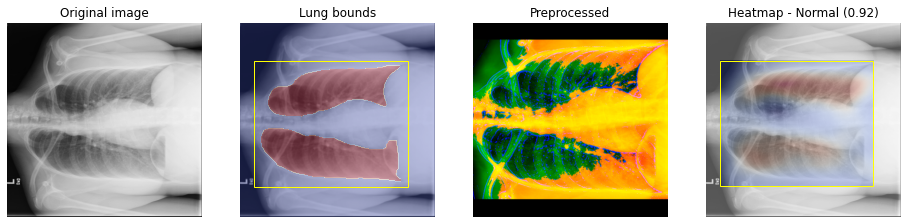

tensor([0.9162], grad_fn=<IndexBackward>)


In [6]:
with HeatmapGenerator(classifier.model[0]) as hmgen:
    xray_files = [Path(img_file)]
    dl = classifier.dls.test_dl(xray_files, bs=64)
    
    for x, in dl:
        output = classifier.model.eval()(x)
        preds = F.softmax(output, dim=1)
        classes = preds.argmax(dim=1)
        conf = preds[np.arange(preds.shape[0]), classes]

#         output.backward(torch.ones_like(output))
        output.backward(output)
        cam_map = hmgen.get_heatmaps()
        out_file = os.path.join(heatmap_dir, os.path.basename(img_file))
        show_heatmaps(x, cam_map, classes, conf, out_file)
        print(conf)